In [1]:
# ============================
# Forecasting Sweden Load Demo
# ============================

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
TZ = "Europe/Stockholm"

# Prophet
from prophet import Prophet

def to_display_df(storage_df: pd.DataFrame, tz: str) -> pd.DataFrame:
    
    """
    Convert storage schema to display schema in tz.
    
    storage_df: columns ["date","zone","load_mw"] in UTC.
    tz: target timezone string, "Europe/Stockholm".
    
    Returns columns ["Date","Load (MW)","zone"] in tz.
    
    """
    
    out = storage_df.copy()
    out["Date"] = out["date"].dt.tz_convert(tz)
    out["Load (MW)"] = out["load_mw"]
    
    return out[["Date", "Load (MW)", "zone"]].sort_values(["zone", "Date"]).reset_index(drop=True)


c:\Users\alber\Desktop\Side_projects\load-forcasting-sweden\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ----------------------------
# 1. Load data
# ----------------------------

In [24]:
DATA_FILE = Path("C:/Users/alber/Desktop/Side_projects/load-forcasting-sweden/data/load_se_zones.parquet")

df = pd.read_parquet(DATA_FILE)
df["date"] = pd.to_datetime(df["date"], utc=True)

# Focus on SE_total
df_total = df[df["zone"] == "SE_total"].copy()

# Sort & ensure continuous
df_total = df_total.sort_values("date").reset_index(drop=True)

#df_total = to_display_df(df_total.copy(), TZ)  # -> ["Date","Load (MW)","zone"] (TZ)


print(df_total.head())

                       date  load_mw      zone
0 2014-12-31 23:00:00+00:00  14706.0  SE_total
1 2015-01-01 00:00:00+00:00  14726.0  SE_total
2 2015-01-01 01:00:00+00:00  14485.0  SE_total
3 2015-01-01 02:00:00+00:00  14298.0  SE_total
4 2015-01-01 03:00:00+00:00  14249.0  SE_total


# ----------------------------
# 2. Train/test split
# ----------------------------

In [25]:
horizon_days = 30
split_date = df_total["date"].max() - pd.Timedelta(days=horizon_days)

train = df_total[df_total["date"] <= split_date]
test = df_total[df_total["date"] > split_date]

print(f"Train: {train['date'].min()} → {train['date'].max()}")
print(f"Test:  {test['date'].min()} → {test['date'].max()}")


Train: 2014-12-31 23:00:00+00:00 → 2025-10-16 12:00:00+00:00
Test:  2025-10-16 13:00:00+00:00 → 2025-11-15 12:00:00+00:00


# ----------------------------
# 3. Naïve baseline
# ----------------------------

In [26]:

# Concatenate to align properly
all_data = pd.concat([train, test], ignore_index=True)

# Weekly seasonal naive: forecast = value 168h before
all_data["naive_forecast"] = all_data["load_mw"].shift(168)

# Keep only test rows
test = all_data.loc[all_data["date"] > split_date].copy()


# ----------------------------
# 4. Prophet model
# ----------------------------

TODO: 

- Add grid search to optimize hyperparameters
- Think of way to smart way to deploy ML model and continuesly train it, train once per week?
- Think of how long in front to forecast? 3 days? A week?
- Add temperature data as a feature
- Add price as feature
- Add ENTSOEs forecast as feature


In [27]:
from prophet.make_holidays import make_holidays_df

# Prophet expects columns 'ds' (datetime, tz-naive) and 'y' (value)
prophet_df = train.rename(columns={"date": "ds", "load_mw": "y"})[["ds", "y"]].copy()
prophet_df["ds"] = prophet_df["ds"].dt.tz_convert(None)  # remove tz

swedish_holidays = make_holidays_df(year_list=range(2015, 2026), country='SE')

model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=0.2,
    changepoint_range=0.95,
    holidays=swedish_holidays,
    interval_width=0.9,
)

model.add_seasonality(name='daily', period=1, fourier_order=8)
model.add_seasonality(name='weekly', period=7, fourier_order=6)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
model.add_seasonality(name='hourly', period=24, fourier_order=17)

model.fit(prophet_df)

# Build future dataframe (tz-naive)
future = pd.DataFrame({
    "ds": pd.date_range(
        start=train["date"].max() + pd.Timedelta(hours=1),
        end=test["date"].max(),
        freq="h"
    ).tz_convert(None)  # strip tz
})

forecast = model.predict(future)

# Merge forecast back to test
forecast_trimmed = forecast[["ds", "yhat"]].rename(columns={"ds": "date", "yhat": "prophet_forecast"})
forecast_trimmed["date"] = pd.to_datetime(forecast_trimmed["date"], utc=True)  # re-attach UTC tz

test = test.merge(forecast_trimmed, on="date", how="left")

16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:29:04 - cmdstanpy - INFO - Chain [1] done processing


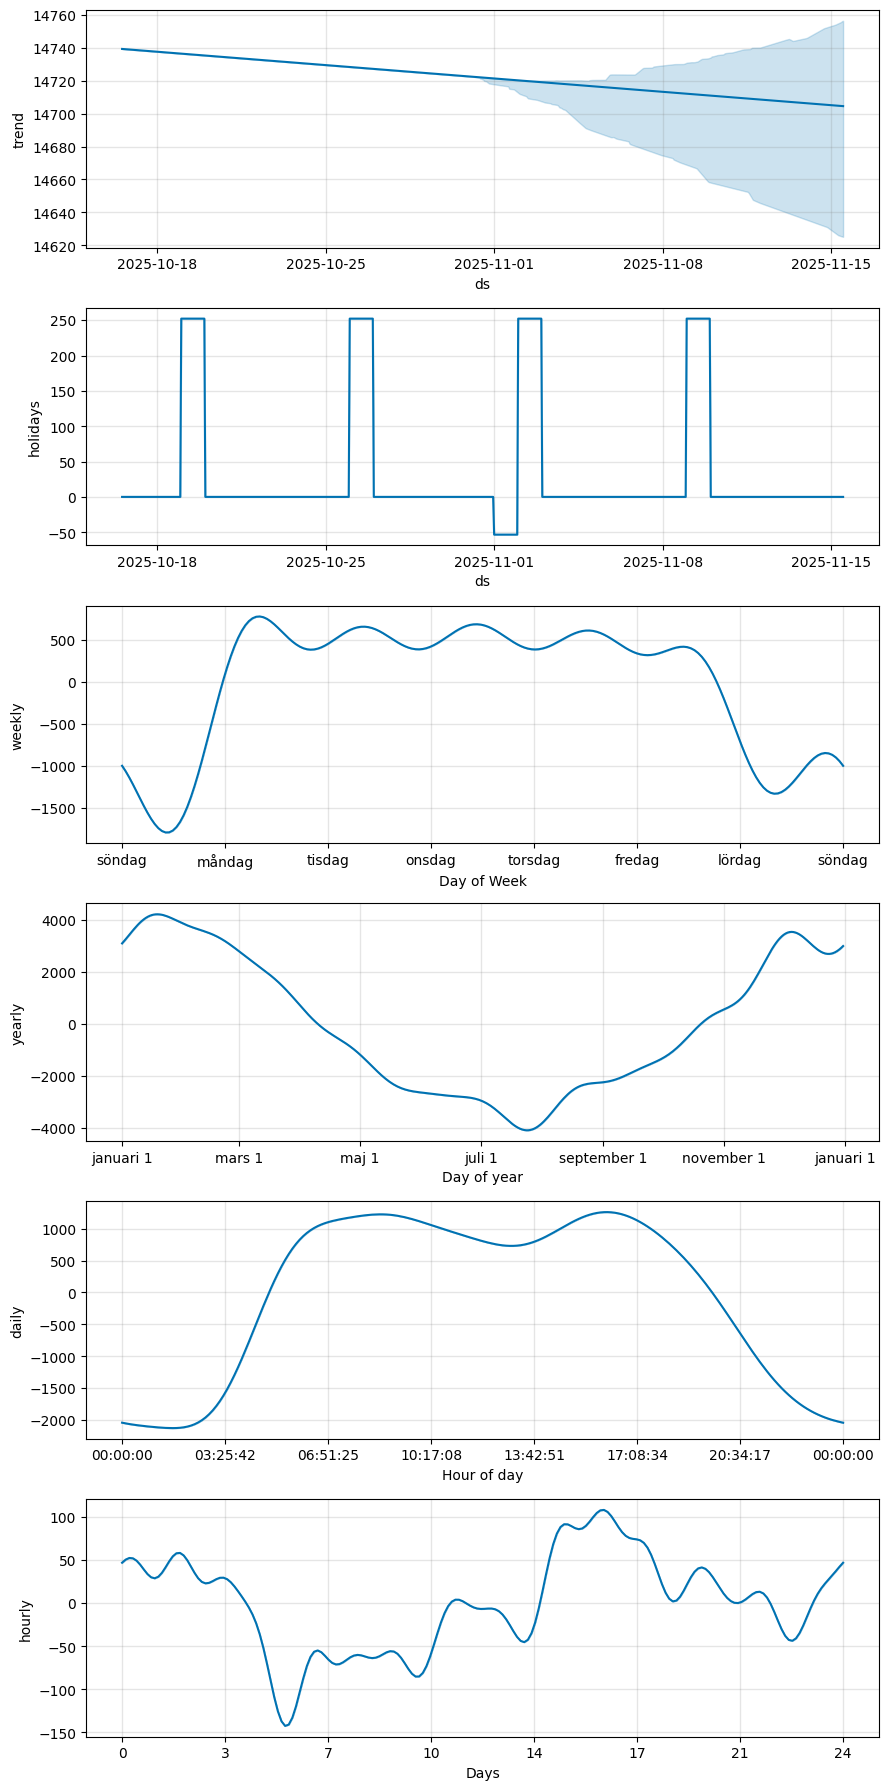

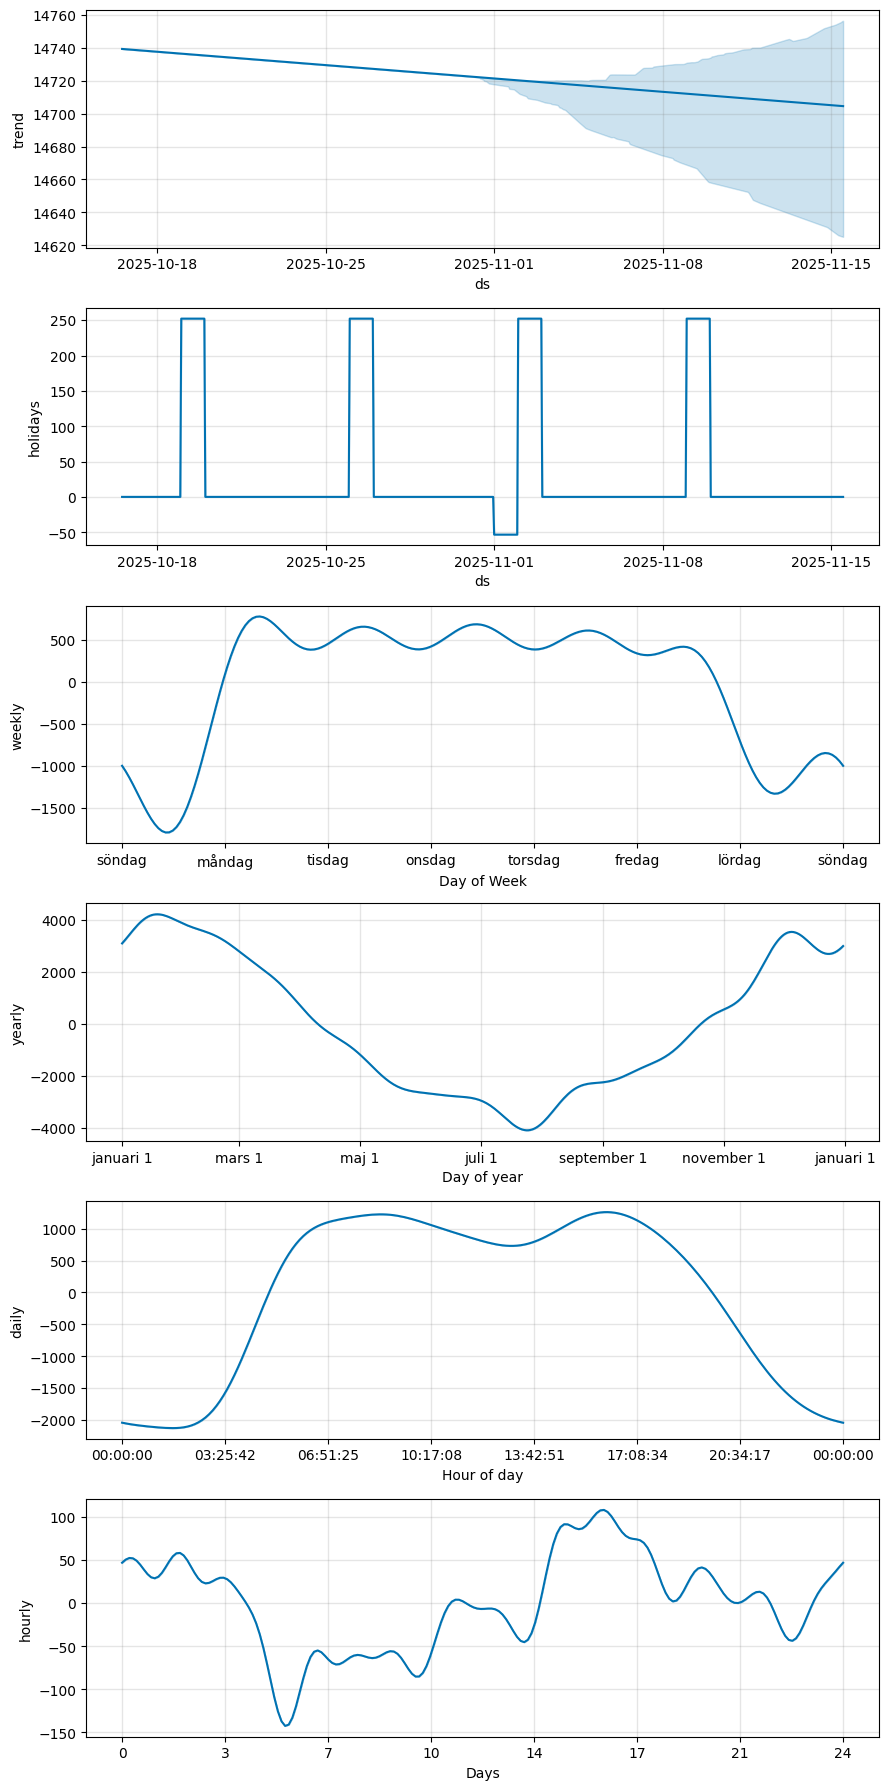

In [28]:
model.plot_components(forecast)

# ----------------------------
# 5. Evaluation metrics
# ----------------------------

In [29]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true)).mean() * 100
    print(f"{label:15s} MAE={mae:.1f}, RMSE={rmse:.1f}, MAPE={mape:.2f}%")

evaluate(test["load_mw"], test["naive_forecast"], "Naive")
evaluate(test["load_mw"], test["prophet_forecast"], "Prophet")



Naive           MAE=1117.5, RMSE=1758487.1, MAPE=7.63%
Prophet         MAE=842.2, RMSE=1082924.8, MAPE=5.91%


# ----------------------------
# 6. Plot results
# ----------------------------

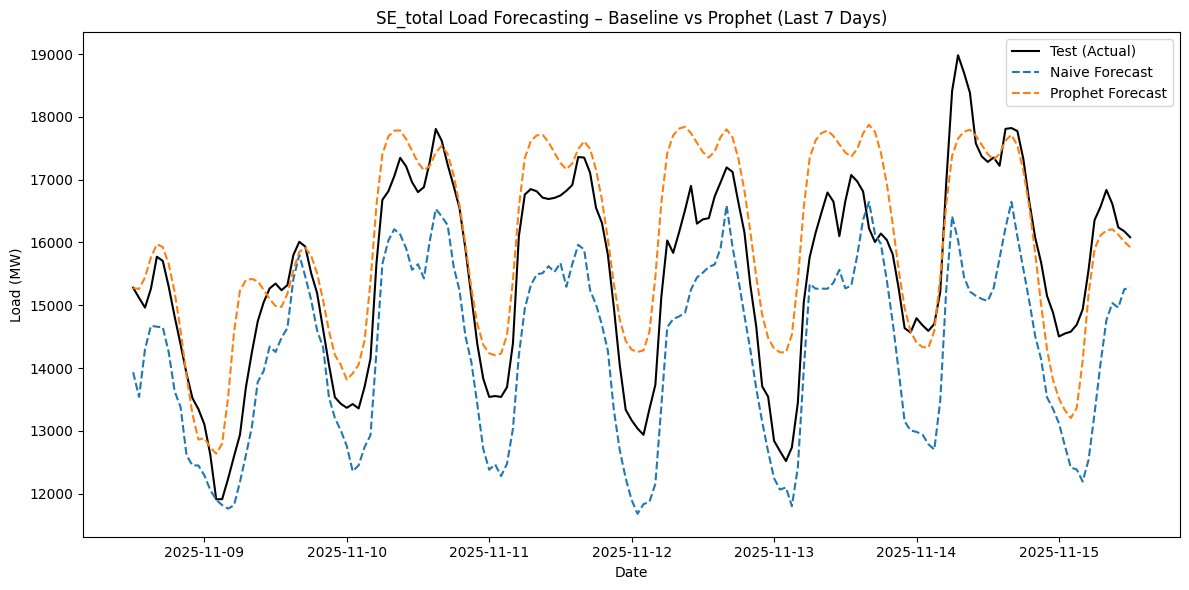

In [31]:
plt.figure(figsize=(12,6))

cutoff = test["date"].max() - pd.Timedelta(days=7)

mask = test["date"] >= cutoff
plt.plot(test.loc[mask, "date"], test.loc[mask, "load_mw"], label="Test (Actual)", color="black")
plt.plot(test.loc[mask, "date"], test.loc[mask, "naive_forecast"], label="Naive Forecast", linestyle="--")
plt.plot(test.loc[mask, "date"], test.loc[mask, "prophet_forecast"], label="Prophet Forecast", linestyle="--")

plt.legend()
plt.title("SE_total Load Forecasting – Baseline vs Prophet (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.tight_layout()
plt.show()